<a href="https://colab.research.google.com/github/diegoramfin/Pairs-Trading-Stat-Arb-Engine/blob/main/Pairs_Trading_Stat_Arbitrage_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pairs Trading/Stat Arb Engine

Project is a fully functional pairs trading engine built on Colab using Python, Pandas, and yFinance. It identifies cointegrated stock pairs and backtests a spread-based long-short strategy with z-scores for entries and exits. Furthermore, project is enhanced with ML to improve Z-score tuning.

In [16]:
!pip install yfinance statsmodels arch

In [17]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [18]:
def get_price_data(tickers, start='2020-01-01', end='2024-12-31'):
    df = yf.download(tickers, start=start, end=end, auto_adjust=False)["Adj Close"]
    return df.dropna()

tickers = ['KO', 'PEP', 'MCD', 'SBUX', 'AAPL', 'MSFT']
prices = get_price_data(tickers)

print(prices.columns)
print(prices.tail())


[*********************100%***********************]  6 of 6 completed

Index(['AAPL', 'KO', 'MCD', 'MSFT', 'PEP', 'SBUX'], dtype='object', name='Ticker')
Ticker            AAPL         KO         MCD        MSFT         PEP  \
Date                                                                    
2024-12-23  254.655716  61.485874  287.984497  433.583038  148.336472   
2024-12-24  257.578674  61.939281  290.653839  437.647400  149.826797   
2024-12-26  258.396667  61.673145  291.454651  436.432068  149.464020   
2024-12-27  254.974930  61.554871  290.288025  428.881104  149.905228   
2024-12-30  251.593079  61.140888  286.313660  423.202911  148.758072   

Ticker           SBUX  
Date                   
2024-12-23  86.360023  
2024-12-24  88.799522  
2024-12-26  90.725426  
2024-12-27  91.110611  
2024-12-30  89.461243  


In [19]:
def find_cointegrated_pairs(data, pvalue_thresh=0.05):
    n = data.shape[1]
    pairs = []
    pvalues = np.ones((n, n))

    for i in range(n):
        for j in range(i+1, n):
            stock1 = data.iloc[:, i]
            stock2 = data.iloc[:, j]
            result = coint(stock1, stock2)
            pvalue = result[1]
            pvalues[i, j] = pvalue
            if pvalue < pvalue_thresh:
                pairs.append((data.columns[i], data.columns[j], pvalue))

    return pairs, pvalues

cointegrated_pairs, _ = find_cointegrated_pairs(prices)
cointegrated_pairs


[]

In [20]:
def johansen_test(data, det_order=-1, k_ar_diff=1):
    result = coint_johansen(data, det_order, k_ar_diff)
    return result.lr1, result.cvt  # eigenvalue test statistic and critical values


In [21]:
def compute_spread(stock1, stock2):
    model = sm.OLS(stock1, sm.add_constant(stock2)).fit()
    spread = stock1 - model.predict(sm.add_constant(stock2))
    return spread

def zscore(series):
    return (series - series.mean()) / np.std(series)

In [68]:
def backtest_pairs_strategy(stock1, stock2, entry_z=1.5, exit_z=0.0): #HERE YOU CAN MANUALLY CHANGE Z SCORES
    spread = compute_spread(stock1, stock2)
    zscores = zscore(spread)

    positions = pd.DataFrame(index=spread.index)
    positions['long_stock1'] = 0
    positions['short_stock2'] = 0

    long_entry = zscores < -entry_z
    short_entry = zscores > entry_z
    exit_condition = abs(zscores) < exit_z

    # Assign using .loc to avoid chained assignment
    positions.loc[long_entry, 'long_stock1'] = 1
    positions.loc[exit_condition, 'long_stock1'] = 0
    positions['long_stock1'] = positions['long_stock1'].ffill().fillna(0)

    positions.loc[short_entry, 'short_stock2'] = -1
    positions.loc[exit_condition, 'short_stock2'] = 0
    positions['short_stock2'] = positions['short_stock2'].ffill().fillna(0)

    # Calculate returns
    returns1 = stock1.pct_change().fillna(0)
    returns2 = stock2.pct_change().fillna(0)

    pnl = positions['long_stock1'] * returns1 + positions['short_stock2'] * returns2
    cumulative_returns = (1 + pnl).cumprod()

    # Return entry_z and exit_z along with other results
    return pnl, cumulative_returns, zscores, entry_z, exit_z

# Manual Z-Score Selection

The following simply showcases the capabilties of the Pairs Trading Engine.

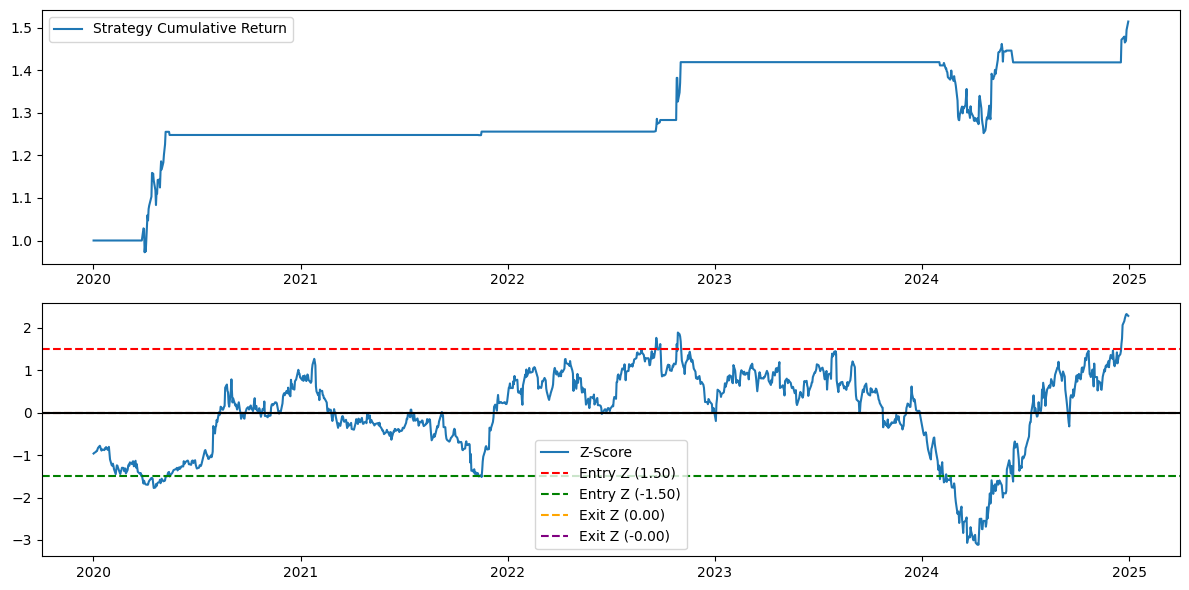

In [69]:
stockA = prices['AAPL']
stockB = prices['MSFT']

# Capture the returned entry_z and exit_z
pnl, cumulative_returns, zscores, entry_z, exit_z = backtest_pairs_strategy(stockA, stockB)

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(cumulative_returns, label='Strategy Cumulative Return')
plt.legend()

plt.subplot(2,1,2)
plt.plot(zscores, label='Z-Score')
plt.axhline(entry_z, color='r', linestyle='--', label=f'Entry Z ({entry_z:.2f})')
plt.axhline(-entry_z, color='g', linestyle='--', label=f'Entry Z ({-entry_z:.2f})')
plt.axhline(exit_z, color='orange', linestyle='--', label=f'Exit Z ({exit_z:.2f})')
plt.axhline(-exit_z, color='purple', linestyle='--', label=f'Exit Z ({-exit_z:.2f})')
plt.axhline(0.0, color='black', linestyle='-')
plt.legend()
plt.tight_layout()
plt.show()

# Iterate through multiple Z-scores and tune to best performing.

---



In [77]:
def optimize_z_thresholds(stock1, stock2, entry_z_range, exit_z_range):
    results = []

    for entry_z in entry_z_range:
        for exit_z in exit_z_range:
            if exit_z >= entry_z:
                continue  # makes no sense to exit when Z is further out than entry

            pnl, cumret, _, _, _ = backtest_pairs_strategy(stock1, stock2, entry_z, exit_z)
            final_return = cumret.iloc[-1]
            sharpe = pnl.mean() / pnl.std() * np.sqrt(252) if pnl.std() != 0 else 0

            results.append({
                'entry_z': entry_z,
                'exit_z': exit_z,
                'final_return': final_return,
                'sharpe': sharpe
            })

    return pd.DataFrame(results).sort_values(by='final_return', ascending=False)

In [78]:
entry_range = np.arange(1.0, 4.0, 0.01)
exit_range = np.arange(0.0, 4.0, 0.01)

stockA = prices['AAPL']
stockB = prices['MSFT']

results_df = optimize_z_thresholds(stockA, stockB, entry_range, exit_range)
print(results_df)


     entry_z  exit_z  final_return    sharpe
28       1.2     0.7      2.321589  1.069052
27       1.2     0.6      2.321589  1.069052
26       1.2     0.5      2.321589  1.069052
29       1.2     0.8      2.321589  1.069052
32       1.2     1.1      2.321589  1.069052
..       ...     ...           ...       ...
117      1.8     0.4      0.930747 -0.251271
118      1.8     0.5      0.930747 -0.251271
119      1.8     0.6      0.930747 -0.251271
120      1.8     0.7      0.930747 -0.251271
121      1.8     0.8      0.930747 -0.251271

[762 rows x 4 columns]


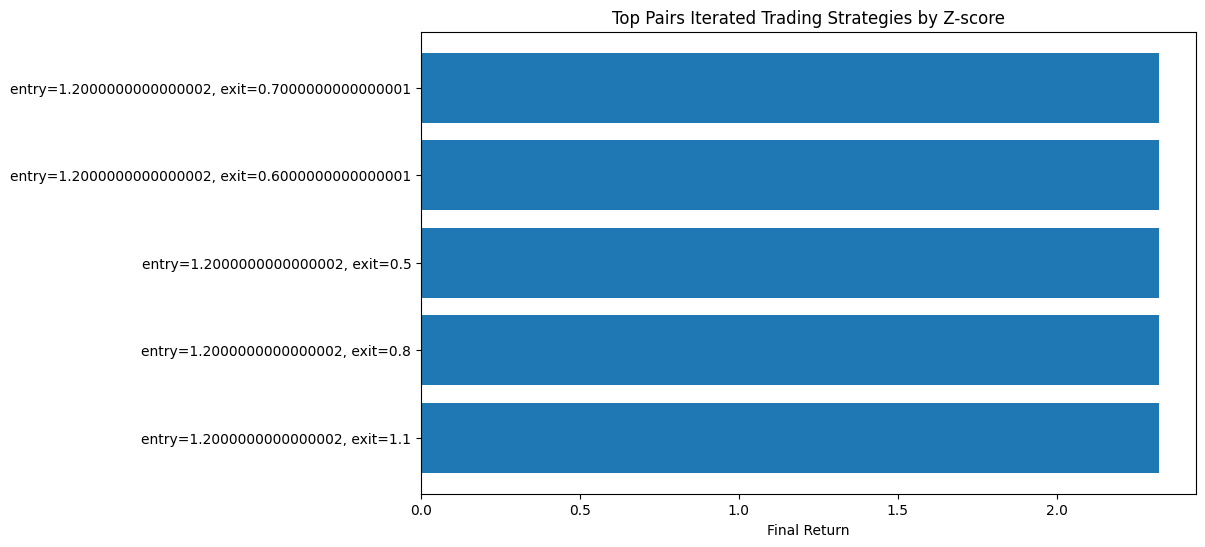

In [111]:
top_n = results_df.head(5)
plt.figure(figsize=(10, 6))
plt.barh(
    [f"entry={row.entry_z}, exit={row.exit_z}" for _, row in top_n.iterrows()],
    top_n['final_return']
)
plt.xlabel("Final Return")
plt.title("Top Pairs Iterated Trading Strategies by Z-score")
plt.gca().invert_yaxis()
plt.show()


Best Strategy: Entry Z=1.2000000000000002, Exit Z=0.7000000000000001


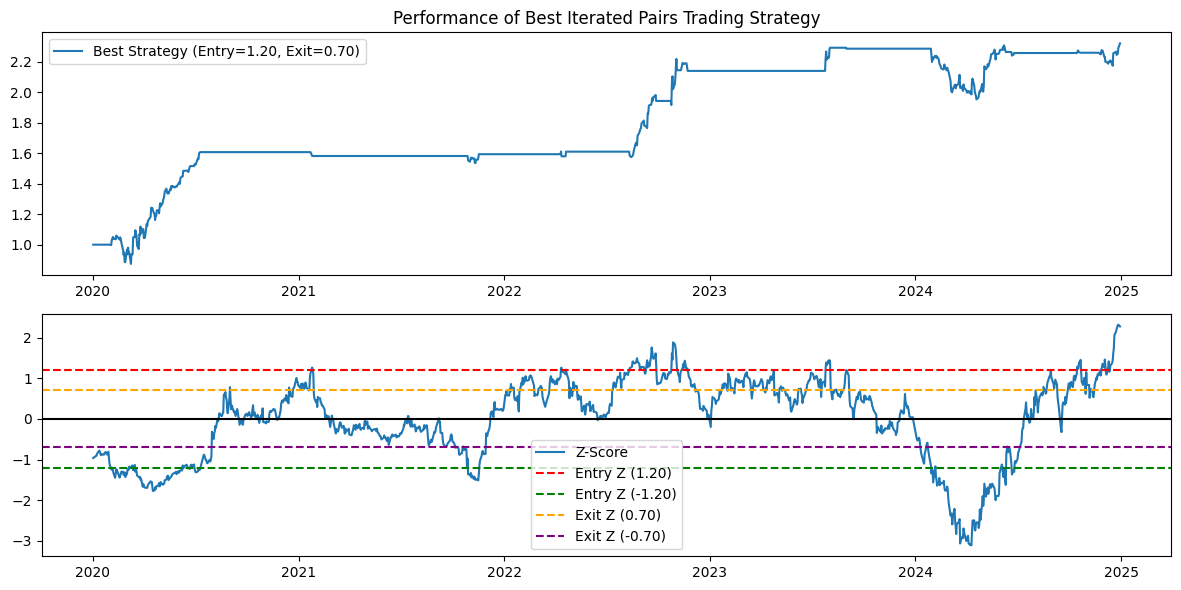

In [112]:
best_strategy = results_df.iloc[0]
best_entry_z = best_strategy['entry_z']
best_exit_z = best_strategy['exit_z']

print(f"Best Strategy: Entry Z={best_entry_z}, Exit Z={best_exit_z}")
pnl, cumulative_returns, zscores, entry_z, exit_z = backtest_pairs_strategy(stockA, stockB, best_entry_z, best_exit_z)

plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(cumulative_returns, label=f'Best Strategy (Entry={best_entry_z:.2f}, Exit={best_exit_z:.2f})')
plt.legend()
plt.title('Performance of Best Iterated Pairs Trading Strategy')

plt.subplot(2,1,2)
plt.plot(zscores, label='Z-Score')
plt.axhline(best_entry_z, color='r', linestyle='--', label=f'Entry Z ({best_entry_z:.2f})')
plt.axhline(-best_entry_z, color='g', linestyle='--', label=f'Entry Z ({-best_entry_z:.2f})')
plt.axhline(best_exit_z, color='orange', linestyle='--', label=f'Exit Z ({best_exit_z:.2f})')
plt.axhline(-best_exit_z, color='purple', linestyle='--', label=f'Exit Z ({-best_exit_z:.2f})')
plt.axhline(0.0, color='black', linestyle='-')
plt.legend()
plt.tight_layout()
plt.show()

# ML Enhancements

In this section I focus on initializing a model to improve the Z-score selection rather than fine tuning manually.

In [93]:
def backtest_pair_strategy(spread, entry_z, exit_z, verbose=False):
    zscore = (spread - spread.mean()) / spread.std()
    position = np.where(zscore > entry_z, -1, np.where(zscore < -entry_z, 1, 0))

    for i in range(1, len(position)):
        if position[i-1] != 0 and abs(zscore[i]) < exit_z:
            position[i] = 0
        elif position[i-1] != 0:
            position[i] = position[i-1]

    spread_ret = spread.pct_change().fillna(0)
    pnl = position[:-1] * spread_ret[1:]
    cumulative_return = np.cumprod(1 + pnl)[-1] - 1
    sharpe = pnl.mean() / pnl.std() * np.sqrt(252) if pnl.std() != 0 else 0

    if verbose:
        print(f"Entry Z: {entry_z}, Exit Z: {exit_z}, Return: {cumulative_return:.4f}, Sharpe: {sharpe:.2f}")

    return {
        "entry_z": entry_z,
        "exit_z": exit_z,
        "return": cumulative_return,
        "sharpe": sharpe,
        "volatility": spread_ret.std(),
        "correlation": spread.corr(spread.shift(1))
    }

In [ ]:
import pandas as pd
import numpy as np

stockA = prices['AAPL']
stockB = prices['MSFT']
spread_series = compute_spread(stockA, stockB)

# Simulated spread for example purposes
spread = (spread_series - spread_series.mean()) / spread_series.std()

results = []

entry_range = np.arange(1.0, 3.1, 0.01)
exit_range = np.arange(0.0, 2.5, 0.01)

for entry_z in entry_range:
    for exit_z in exit_range:
        if exit_z >= entry_z:
            continue
        result = backtest_pair_strategy(spread, entry_z, exit_z)
        results.append(result)

df = pd.DataFrame(results)


/tmp/ipython-input-3333223458.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if position[i-1] != 0 and abs(zscore[i]) < exit_z:
/tmp/ipython-input-3333223458.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = np.cumprod(1 + pnl)[-1] - 1
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-1493161271.py", line 20, in <cell line: 0>
    result = backtest_pair_strategy(spread, entry_z, exit_z)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3333223458.py", line None, in backtest_pair_strategy
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-pa

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

features = ['entry_z', 'exit_z', 'volatility', 'correlation']
target = 'return'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)

print("R² score:", model.score(X_test, y_test))


In [106]:
def find_best_z(model, vol, corr):
    best_return = -np.inf
    best_pair = None

    for entry_z in np.arange(1.0, 3.1, 0.1):
        for exit_z in np.arange(0.0, entry_z, 0.01):
            X_new = pd.DataFrame([{
                'entry_z': entry_z,
                'exit_z': exit_z,
                'volatility': vol,
                'correlation': corr
            }])
            pred = model.predict(X_new)[0]
            if pred > best_return:
                best_return = pred
                best_pair = (entry_z, exit_z)

    return best_pair, best_return


In [ ]:
vol = spread.pct_change().std()
corr = spread.corr(spread.shift(1))

(best_entry, best_exit), pred_return = find_best_z(model, vol, corr)

print(f"ML-Recommended Z thresholds: Entry {best_entry}, Exit {best_exit}")
print(f"Predicted return: {pred_return:.4f}")


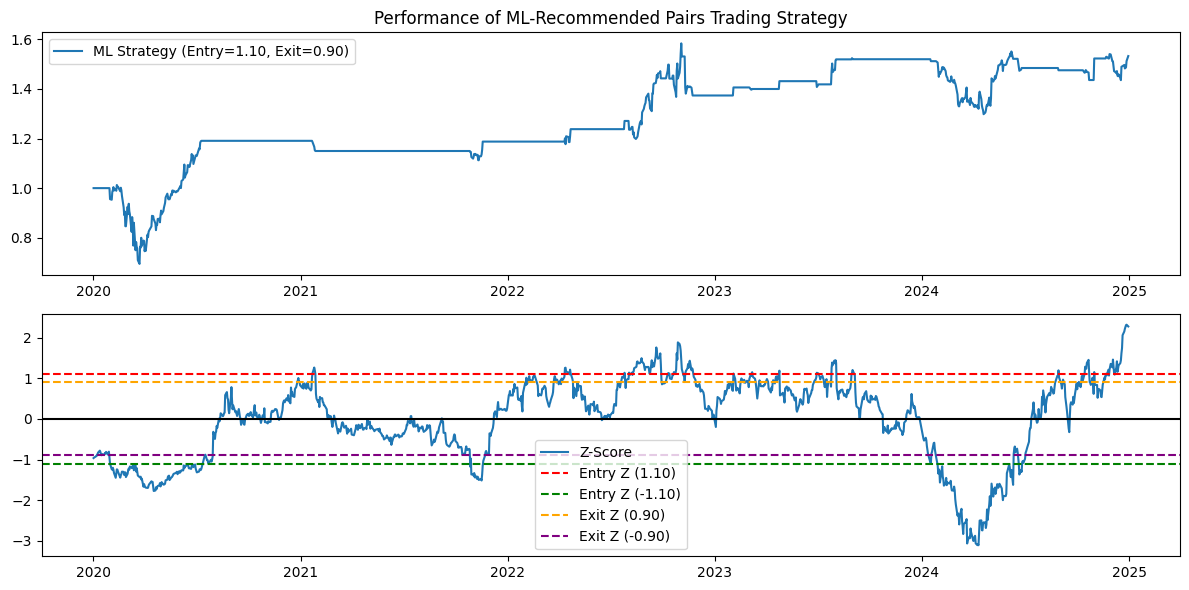

In [108]:
# Backtest the strategy with ML-recommended thresholds
pnl_ml, cumulative_returns_ml, zscores_ml, entry_z_ml, exit_z_ml = backtest_pairs_strategy(stockA, stockB, best_entry, best_exit)

# Plot the performance of the ML-recommended strategy
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(cumulative_returns_ml, label=f'ML Strategy (Entry={best_entry:.2f}, Exit={best_exit:.2f})')
plt.legend()
plt.title('Performance of ML-Recommended Pairs Trading Strategy')

plt.subplot(2,1,2)
plt.plot(zscores_ml, label='Z-Score')
plt.axhline(best_entry, color='r', linestyle='--', label=f'Entry Z ({best_entry:.2f})')
plt.axhline(-best_entry, color='g', linestyle='--', label=f'Entry Z ({-best_entry:.2f})')
plt.axhline(best_exit, color='orange', linestyle='--', label=f'Exit Z ({best_exit:.2f})')
plt.axhline(-best_exit, color='purple', linestyle='--', label=f'Exit Z ({-best_exit:.2f})')
plt.axhline(0.0, color='black', linestyle='-')
plt.legend()
plt.tight_layout()
plt.show()